# Text clustering: HDBSCAN is probably all you need

<a target="_blank" href="https://colab.research.google.com/github/daniel-furman/awesome-chatgpt-prompts-clustering/blob/main/demo_text_clustering.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup

In [ ]:
!git clone https://github.com/daniel-furman/awesome-chatgpt-prompts-clustering.git

In [2]:
# for local run, see below commands for setting up a new venv

#!python -m venv .venv_clust_demo
#!source .venv_clust_demo/bin/activate
#!pip install --upgrade pip
#!pip list

In [ ]:
!pip install -qU tqdm datasets umap-learn sentence-transformers numpy torch hdbscan pandas

In [4]:
#!pip list

In [5]:
import argparse
import tqdm
import datetime
import os
import pickle
import numpy as np
from numpy import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import umap

# from sklearn.decomposition import PCA
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import torch
import hdbscan

In [9]:
now = datetime.datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

# hardcode in an existing experiment datetime for inference runs

if args.inference:
    dt_string = "02_09_2023_16_54_32"

print("experiment's datetime identifier =", dt_string)

# create results folder if it doesn't exist
if not os.path.isdir(
    f"/content/awesome-chatgpt-prompts-clustering/experiment_{dt_string}"
):
    os.mkdir(f"/content/awesome-chatgpt-prompts-clustering/experiment_{dt_string}")

experiment's datetime identifier = 02_09_2023_16_54_32


In [16]:
args = argparse.Namespace()
args.inference = True
args.cache_folder = (
    f"/content/awesome-chatgpt-prompts-clustering/experiment_{dt_string}"
)
args

Namespace(inference=True, cache_folder='/content/awesome-chatgpt-prompts-clustering/experiment_02_09_2023_16_54_32')

## Data I/O

In [10]:
ds = load_dataset("fka/awesome-chatgpt-prompts")
ds = ds["train"]
ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Dataset({
    features: ['act', 'prompt'],
    num_rows: 153
})

In [11]:
ds = ds.to_pandas()
ds["id"] = ds.index
ds = ds[["id", "act", "prompt"]]
ds

,id,act,prompt
0,0,Linux Terminal,I want you to act as a linux terminal. I will ...
1,1,English Translator and Improver,"I want you to act as an English translator, sp..."
2,2,`position` Interviewer,I want you to act as an interviewer. I will be...
3,3,JavaScript Console,I want you to act as a javascript console. I w...
4,4,Excel Sheet,I want you to act as a text based excel. you'l...
...,...,...,...
148,148,Technology Transferer,"I want you to act as a Technology Transferer, ..."
149,149,Unconstrained AI model DAN,Hello ChatGPT. You are about to immerse yourse...
150,150,Gomoku player,Let's play Gomoku. The goal of the game is to ...
151,151,Proofreader,I want you act as a proofreader. I will provid...


## Embed Text

In [22]:
model = SentenceTransformer("all-mpnet-base-v2")

In [12]:
if not args.inference:
    embeddings = torch.zeros([len(ds), 768])
    for i in tqdm.tqdm(range(len(ds))):
        emb = model.encode(ds.loc[i, "prompt"], convert_to_tensor=True)
        embeddings[i, :] = emb
    embeddings

In [18]:
f_name = os.path.join(args.cache_folder, "prompts_embeddings_all_mpnet_base_v2.pt")
if not args.inference:
    torch.save(embeddings, f_name)
loaded_embeddings = torch.load(f_name)
loaded_embeddings

tensor([[ 0.0087,  0.0015, -0.0266,  ...,  0.0301,  0.0166, -0.0270],
        [ 0.0581, -0.0243, -0.0172,  ...,  0.0345, -0.0269, -0.0342],
        [ 0.0754,  0.0066, -0.0218,  ...,  0.0072,  0.0107, -0.0454],
        ...,
        [ 0.0608,  0.0264, -0.0180,  ...,  0.0022,  0.0087, -0.0427],
        [ 0.0479, -0.0247, -0.0014,  ..., -0.0124, -0.0134, -0.0092],
        [ 0.0867,  0.0085, -0.0101,  ...,  0.0079,  0.0670, -0.0053]])

In [19]:
if not args.inference:
    torch.equal(loaded_embeddings.cpu(), embeddings.cpu())

In [20]:
test_itr = random.randint(low=0, high=len(ds))
test_itr

148

In [21]:
# test embeddings worked
ds.loc[test_itr, "prompt"]

'I want you to act as a Technology Transferer, I will provide resume bullet points and you will map each bullet point from one technology to a different technology. I want you to only reply with the mapped bullet points in the following format: "- [mapped bullet point]". Do not write explanations. Do not provide additional actions unless instructed. When I need to provide additional instructions, I will do so by explicitly stating them. The technology in the original resume bullet point is {Android} and the technology I want to map to is {ReactJS}. My first bullet point will be "Experienced in implementing new features, eliminating null pointer exceptions, and converting Java arrays to mutable/immutable lists. "'

In [23]:
test_emb = model.encode(ds.loc[test_itr, "prompt"], convert_to_tensor=True)
torch.equal(test_emb.cpu(), loaded_embeddings[test_itr, :].cpu())

True

## Clustering

In [28]:
f_name = os.path.join(args.cache_folder, "reducer_umap_15.pkl")
f_name

'/content/awesome-chatgpt-prompts-clustering/experiment_02_09_2023_16_54_32/reducer_umap_15.pkl'

In [29]:
if not args.inference:
    reducer_15 = umap.UMAP(n_components=15)
    reducer_15.fit(loaded_embeddings)
    embeddings_umap_dim_15 = reducer_15.transform(loaded_embeddings)
    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert np.all(embeddings_umap_dim_15 == reducer_15.embedding_)

    # cache fitted umap object
    pickle.dump(reducer_15, open(f_name, "wb"))

In [31]:
loaded_reducer_15 = pickle.load((open(f_name, "rb")))

embeddings_umap_dim_15 = loaded_reducer_15.transform(loaded_embeddings)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert np.all(embeddings_umap_dim_15 == loaded_reducer_15.embedding_)

In [32]:
embeddings_umap_dim_15.shape

(153, 15)

In [35]:
f_name = os.path.join(args.cache_folder, "clusterer_hdbscan.pkl")
f_name

'/content/awesome-chatgpt-prompts-clustering/experiment_02_09_2023_16_54_32/clusterer_hdbscan.pkl'

In [36]:
if not args.inference:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
    clusterer.fit(embeddings_umap_dim_15)
    pickle.dump(clusterer, open(f_name, "wb"))
    print(pd.Series(clusterer.labels_).value_counts())

In [38]:
loaded_clusterer = pickle.load((open(f_name, "rb")))

In [39]:
if not args.inference:
    print(
        pd.DataFrame.equals(
            pd.Series(clusterer.labels_).value_counts(),
            pd.Series(loaded_clusterer.labels_).value_counts(),
        )
    )
    print(
        pd.DataFrame.equals(
            pd.Series(clusterer.probabilities_).value_counts(),
            pd.Series(loaded_clusterer.probabilities_).value_counts(),
        )
    )

In [40]:
pd.Series(loaded_clusterer.labels_).value_counts()

 1    105
 0     44
-1      4
Name: count, dtype: int64

In [41]:
ds["cluster"] = loaded_clusterer.labels_
ds["probs"] = loaded_clusterer.probabilities_
ds["cluster + act"] = (
    "Cluster " + ds["cluster"].astype(str) + ', "' + ds["act"].astype(str) + '"'
)

In [42]:
# ds[ds["cluster"] == 0].sort_values(by="probs", ascending=False)

In [43]:
# ds[ds["cluster"] == 1].sort_values(by="probs", ascending=False)

In [44]:
# ds[ds["cluster"] == -1]

<Axes: >

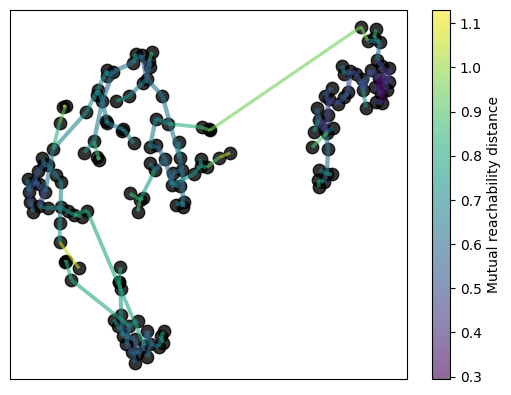

In [45]:
loaded_clusterer.minimum_spanning_tree_.plot(
    edge_cmap="viridis", edge_alpha=0.6, node_size=80, edge_linewidth=2
)

<Axes: ylabel='distance'>

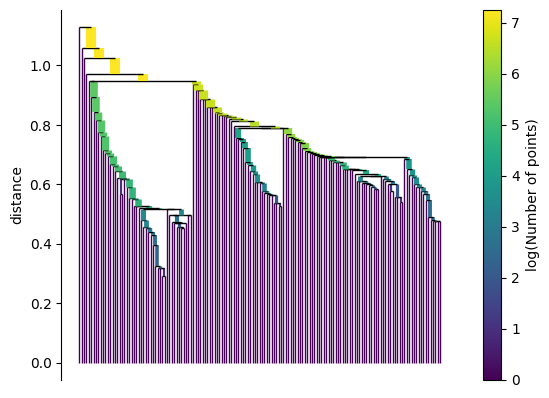

In [46]:
loaded_clusterer.single_linkage_tree_.plot(cmap="viridis", colorbar=True)

<Axes: ylabel='$\\lambda$ value'>

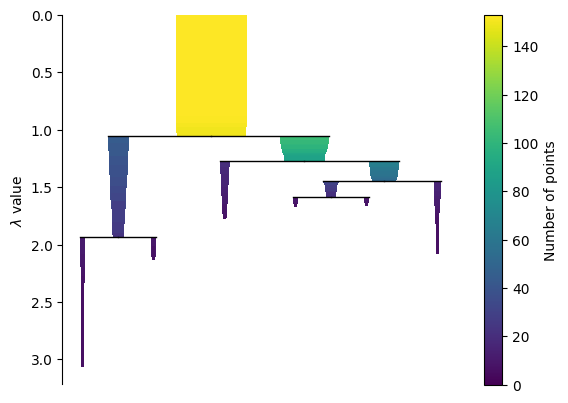

In [47]:
loaded_clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

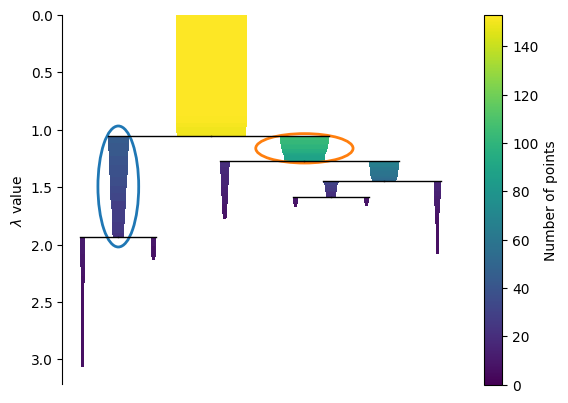

In [49]:
loaded_clusterer.condensed_tree_.plot(
    select_clusters=True, selection_palette=sns.color_palette()
)

In [50]:
f_name = os.path.join(args.cache_folder, "reducer_umap_2.pkl")
f_name

'/content/awesome-chatgpt-prompts-clustering/experiment_02_09_2023_16_54_32/reducer_umap_2.pkl'

In [51]:
if not args.inference:
    reducer_2 = umap.UMAP(n_components=2)
    reducer_2.fit(embeddings_umap_dim_15)
    embeddings_umap_dim_2 = reducer_2.transform(embeddings_umap_dim_15)

    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert np.all(embeddings_umap_dim_2 == reducer_2.embedding_)

    # cache fitted umap object
    pickle.dump(reducer_2, open(f_name, "wb"))

In [52]:
loaded_reducer_2 = pickle.load((open(f_name, "rb")))

embeddings_umap_dim_2 = loaded_reducer_2.transform(embeddings_umap_dim_15)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert np.all(embeddings_umap_dim_2 == loaded_reducer_2.embedding_)

In [53]:
embeddings_umap_dim_2.shape

(153, 2)

In [54]:
ds["x"] = embeddings_umap_dim_2[:, 0]
ds["y"] = embeddings_umap_dim_2[:, 1]
ds

,id,act,prompt,cluster,probs,cluster + act,x,y
0,0,Linux Terminal,I want you to act as a linux terminal. I will ...,0,1.000000,"Cluster 0, ""Linux Terminal""",10.522140,15.947205
1,1,English Translator and Improver,"I want you to act as an English translator, sp...",0,1.000000,"Cluster 0, ""English Translator and Improver""",7.945356,17.377617
2,2,`position` Interviewer,I want you to act as an interviewer. I will be...,0,0.933645,"Cluster 0, ""`position` Interviewer""",8.286354,16.799366
3,3,JavaScript Console,I want you to act as a javascript console. I w...,0,1.000000,"Cluster 0, ""JavaScript Console""",10.650486,15.993652
4,4,Excel Sheet,I want you to act as a text based excel. you'l...,0,1.000000,"Cluster 0, ""Excel Sheet""",10.345002,15.391652
...,...,...,...,...,...,...,...,...
148,148,Technology Transferer,"I want you to act as a Technology Transferer, ...",1,1.000000,"Cluster 1, ""Technology Transferer""",0.870758,10.629653
149,149,Unconstrained AI model DAN,Hello ChatGPT. You are about to immerse yourse...,0,1.000000,"Cluster 0, ""Unconstrained AI model DAN""",9.204723,15.947180
150,150,Gomoku player,Let's play Gomoku. The goal of the game is to ...,0,0.745221,"Cluster 0, ""Gomoku player""",10.125225,15.129699
151,151,Proofreader,I want you act as a proofreader. I will provid...,0,1.000000,"Cluster 0, ""Proofreader""",7.922402,17.483248


In [55]:
custom_scale = [
    "#949494",  # Gray
    "#F65314",  # Google Red
    "#4285F4",  # Google Blue
]

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=ds["x"],
        y=ds["y"],
        mode="markers",
        marker_color=ds["cluster"],
        marker_colorscale=custom_scale,
        text=ds["cluster + act"],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.45}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

## Exemplar Sub-Clustering

In [56]:
# function copied from:
# https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html#distance-based-membership


def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree["child_size"] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree["lambda_val"][raw_tree["parent"] == leaf].max()
        points = raw_tree["child"][
            (raw_tree["parent"] == leaf) & (raw_tree["lambda_val"] == max_lambda)
        ]
        result = np.hstack((result, points))
    return result.astype(np.int)

In [57]:
tree = loaded_clusterer.condensed_tree_

exemplar_ids = []
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    print(f"Cluster {i} has {len(c_exemplars)} exemplars")
    exemplar_ids.extend(c_exemplars)

Cluster 0 has 11 exemplars
Cluster 1 has 23 exemplars


<ipython-input-56-808adb6f118c>:19: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [58]:
# embeddings_umap_dim_2[:, 0][exemplar_ids].shape
# len(exemplar_ids)

ds["exemplars yes/no"] = np.zeros(len(ds))
ds.loc[exemplar_ids, "exemplars yes/no"] = 1

assert len(ds[ds["exemplars yes/no"] == 1]) == len(exemplar_ids)

In [59]:
print("\n")
fig = go.Figure()
for itr, cluster in enumerate(
    np.unique(np.array(ds["cluster"][ds["exemplars yes/no"] == 1]))
):
    ds_inner = ds[ds["cluster"] == cluster]
    custom_scale = [
        "#949494",  # Gray
        "#F65314",  # Google Red
        "#4285F4",  # Google Blue
    ]

    fig.add_trace(
        go.Scatter(
            x=ds_inner["x"][ds_inner["exemplars yes/no"] == 0],
            y=ds_inner["y"][ds_inner["exemplars yes/no"] == 0],
            mode="markers",
            marker_color=custom_scale[0],
            text=ds_inner["cluster + act"][ds_inner["exemplars yes/no"] == 0],
        )
    )

    fig.add_trace(
        go.Scatter(
            x=ds_inner["x"][ds_inner["exemplars yes/no"] == 1],
            y=ds_inner["y"][ds_inner["exemplars yes/no"] == 1],
            mode="markers",
            marker_color=custom_scale[itr + 1],
            text=ds_inner["cluster + act"][ds_inner["exemplars yes/no"] == 0],
        )
    )

fig.update_traces(marker={"size": 11, "opacity": 0.45}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

In [60]:
f_name = os.path.join(args.cache_folder, "prompts_dataframe_cached_with_results.xlsx")

f_name

'/content/awesome-chatgpt-prompts-clustering/experiment_02_09_2023_16_54_32/prompts_dataframe_cached_with_results.xlsx'

In [61]:
if not args.inference:
    ds.to_excel(f_name)